# full exp:
- gridsearch blocked/interleaved, using MSE human as eval metric
    - fix parameters
- eval fit on early/middle/late conditions

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.stats import zscore
from utils import *
import pandas as pd
from glob import glob as glob
import seaborn as sns
sns.set_context('talk')

In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### human data for plotting

In [3]:
##  load human data for fitting
humandf = pd.read_csv('humandf.csv')
human_accD = {}
condL =['blocked','interleaved','early','middle','late']
for cond in condL:
    human_accD[cond] = humandf.loc[:,'%s mean'%cond].values
human_accD['single'] = humandf.loc[:,'blocked mean'].values # debug
# 1d arrs of acc
human_accD['blocked'].shape,human_accD.keys()

((200,),
 dict_keys(['blocked', 'interleaved', 'early', 'middle', 'late', 'single']))

# full experiment

In [4]:
def run_exp(nseeds,condL,paramD,ntr=160,nte=40):
    """ returns acc for cond in condL 
    """
    print('N=%i'%nseeds,paramD)
    acc = -np.ones([len(condL),nseeds,ntr+nte])
    sch = -np.ones([len(condL),nseeds,ntr+nte,3])
    ct = [[],[]]
    for ci,cond in enumerate(condL):
        for s in range(nseeds):
            # seed ctrl
            np.random.seed(s)
            tr.manual_seed(s)
            # init
            ag = Agent(**paramD)
            task = Task()
            # run
            exp,cur = task.generate_experiment(cond,ntr,nte)
            data_seed = ag.forward_exp(exp) 
            acc[ci,s] = data_seed['acc']
            sch[ci,s] = data_seed['sch']
            ct[ci].extend([i.nupdates for i in ag.schlib])
    data = {'acc':acc,'sch':sch,'ct':ct}
    return data
  
def plt_human(ax=None,condL=['blocked'],c='k'):
  for cond in condL:
    ax.plot(human_accD[cond],
            c=c,zorder=-99,alpha=0.4
           )
  return None

def plt_acc(acc,condL,ax=None,h=1):
  # model
  for ac in acc:
    ax.plot(ac.mean(0))
  # human plot
  if h:
    plt_human(ax=ax,condL=condL)
  ax.set_ylim(0.2,1)    
  return None

### blocked / interleaved plots

In [5]:
bestparamD = {
  'pe_thresh_decay': 0.04, 
  'pe_thresh0': 7, 
  'init_lr': 0.4, 
  'lr_decay': 0.25, 
  'stsize': 6.0
}

In [6]:
ns = 15
condBI = ['blocked','interleaved'] # debug
data = run_exp(nseeds=ns,
              condL=condBI,
              paramD=bestparamD,
              ntr=160, nte=40 # debug
             )

N=15 {'pe_thresh_decay': 0.04, 'pe_thresh0': 7, 'init_lr': 0.4, 'lr_decay': 0.25, 'stsize': 6.0}


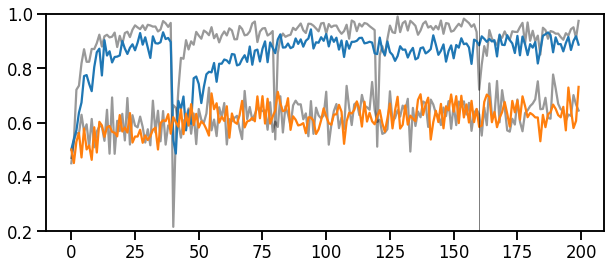

In [7]:
plt.subplots(figsize=(10,4))
ax = plt.gca()
acc_bestBI = data['acc']
plt_acc(acc_bestBI,condBI,ax=ax)
ax.axvline(160,c='k',lw=0.5)
# ax.set_xlim(0,45)
plt.savefig('figures/acc-dynamicthresh')

(2, 15, 199, 3)
(199, 3)
(199, 3)


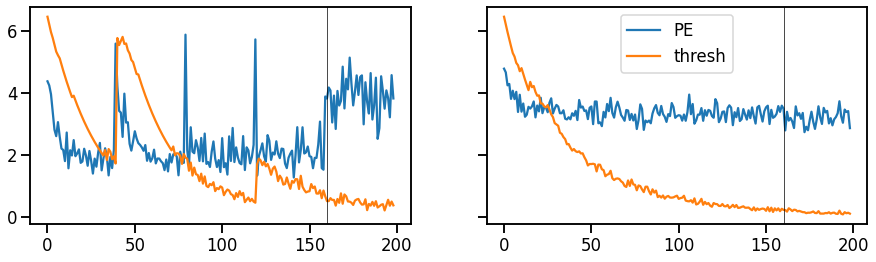

In [8]:
schdata = data['sch'][:,:,1:,:] 

print(schdata.shape)
f,axa = plt.subplots(1,2,figsize=(15,4),sharey=True)
for i in range(2):
  ax = axa[i]
  for sdata in schdata[i:i+1]:
    M = sdata.mean(0)
    print(M.shape)
    ax.plot(M[:,0],label='PE')
    ax.plot(M[:,1],label='thresh')
    ax.axvline(160,c='k',lw=0.7)
ax.legend()

In [9]:
assert False

AssertionError: 

# more plots

In [ ]:
f,axar = plt.subplots(3,1,figsize=(12,9),sharex=True)
tL = ['pe<thresh','stay_lapse','new_schema']
for j in range(3):
  ax = axar[j]
  for si,sch in enumerate(data['sch']):
    # pe<thresh
    s = np.count_nonzero(sch==j,0)/len(sch)
    ax.plot(s[1:])
    ax.set_ylim(0,1.05)
    ax.set_title(tL[j])
    ax.axvline(160,c='k',lw=0.5)
ax.set_xlabel('trial')
ax.set_ylabel('proportion of N=%i seeds'%len(sch))
plt.savefig('figures/splitting')

In [ ]:
f,axar = plt.subplots(1,2,figsize=(16,6),sharex=True)
tL = ['blocked','interleaved']
for ci,ct in enumerate(data['ct']):
  ax=axar[ci]
  ax.set_title(tL[ci])
  ct_plt = np.array(ct)
  ax.hist(ct_plt,range=(0,200),bins=100)
  ax.set_ylim(0,20)
  ax.axvline(100,c='k',lw=0.5)
axar[0].set_ylabel('frequency across N=%i seeds'%ns)
axar[0].set_xlabel('schema reuse count')
plt.savefig('figures/scount')

### early / middle / late plots

In [ ]:
condEML=['early','middle','late']
ns = 50
acc_bestEML = run_exp(nseeds=ns,
              condL=condEML,
              paramD=bestparamD
             )

In [ ]:
f,ax = plt.subplots(3,1,figsize=(10,10),sharex=True)
for ci in range(3):
  cond = condEML[ci]
  plt_acc([acc_bestEML[ci]],[cond],ax=ax[ci])
  ax[ci].set_title(cond)

# analysis of splitting